In [39]:
import numpy as np
import os.path as op
from pandas import read_csv
import mne
from mne.io import read_raw_fif
from mne.datasets import visual_92_categories
from neurora.nps_cal import nps
from neurora.rdm_cal import eegRDM
from neurora.rdm_corr import rdm_correlation_spearman
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.rsa_plot import plot_rdm, plot_corrs_by_time, plot_nps_hotmap, plot_corrs_hotmap
import pandas as pd

In [40]:
list_epochs_all = list()


# DD
sub_ids = [

     "pre4002_y","pre4004_y","pre4004_y","pre4005_y","pre4010_y","pre4012_y","pre4013_y"

]
# # 正常儿童
# sub_ids = [
#
#      "pre4003_y","pre4007_y","pre4008_y","pre4009_y","pre4011_y","pre4012_y","pre4013_y"
#
# ]

file_path = 'E:\实验\阅读困难\数据处理\pre4\data\\6epoch_clean_RSA\\'
channels_nieye = ['M1','T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']
channels_nieye = ['T7','P7','TP7','M2','T8','P8','TP8','CP5','CP6','C5','C6']
channels_all = ['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'O1', 'Oz', 'O2', ]

num_channel = len(channels_nieye)

for sub_id in sub_ids:
    data_path = file_path + sub_id + '_RSA-epo.fif'

    epochs_all = mne.read_epochs(fname=data_path)
    # 如果只想看某一部分的脑区,配合更改ndarray的维度
    epochs_all = epochs_all.pick(picks=channels_nieye)

    list_epochs_all.append(epochs_all)

'''
思路，先求ERP，然后再给ndarray，然后再计算RDM
'''

Reading E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_RSA\pre4002_y_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1440 matching events found
No baseline correction applied
0 projection items activated
Reading E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_RSA\pre4004_y_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1340 matching events found
No baseline correction applied
0 projection items activated
Reading E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_RSA\pre4004_y_RSA-epo.fif ...
    Found the data of interest:
        t =    -200.00 ...     800.00 ms
        0 CTF compensation matrices available
Not setting metadata
1340 matching events found
No baseline correction applied
0 projection items activated
Reading E:\实验\阅读困难\数据处理\pre4\data\6epoch_clean_RSA\pre4005_y_RSA-epo.fif ...
    Found t

'\n思路，先求ERP，然后再给ndarray，然后再计算RDM\n'

In [41]:

'''
生成每种条件对应的evoked
而且是按照次序
'''
conds = ['101', '102', '103', '104', '111', '112', '113', '114', '121', '122', '123', '124', '131', '132', '133', '134', ]

eegdata = np.zeros([len(sub_ids),16, num_channel, 1001], dtype=np.float32)
#初始值
subindex = 0
for m in range(len(sub_ids)):
    #单个被试的数据
    subdata = np.zeros([16, num_channel, 1001], dtype=np.float32)
    for i in range(len(conds)):
        epochs = list_epochs_all[m][conds[i]]
        evoked = epochs.average()
        data = evoked.data
        subdata[i] = data
    eegdata[m] = subdata

In [42]:
# shape of megdata: [n_subs, n_cons, n_chls, n_ts] -> [n_cons, n_subs, n_chls, n_ts]
eegdata = np.transpose(eegdata, (1, 0, 2, 3))

# shape of megdata: [n_cons, n_subs, n_chls, n_ts] -> [n_cons, n_subs, n_trials, n_chls, n_ts]
# here data is averaged, so set n_trials = 1
eegdata = np.reshape(eegdata, [16, len(sub_ids), 1, num_channel, 1001])



Computing RDMs

RDMs computing finished!


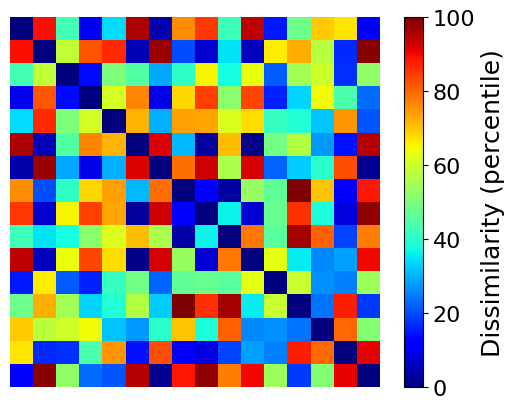

0

In [43]:
# Calculate the RDM based on the data during 190ms-210ms
#sub_opt=1 indicate不止一个被试。
#The shape of EEGdata must be [n_cons, n_subs, n_trials, n_chls, n_ts].
# Sometimes, the numbers of trials under different conditions are not same. In NeuroRA, we recommend users to average
#     the trials under a same condition firstly in this situation. Thus, the shape of input (EEG_data) should be
#     [n_cons, n_subs, 1, n_chls, n_ts].


rdm = eegRDM(eegdata[:, :, :, :, 340:350])
# Plot this RDM
plot_rdm(rdm[0], percentile=True)

In [44]:
# Calculate the RDMs by a 10ms time-window
# (raw sampling requency is 1000Hz, so here time_win=10ms/(1s/1000Hz)/1000=10)
# sub_opt = 1

# 默认窗口是50，那么就是 （1000-50）/5 = 190
rdms = eegRDM(eegdata, time_opt=1, time_win=50, time_step=5, sub_opt=1)


Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDMs computing finished!


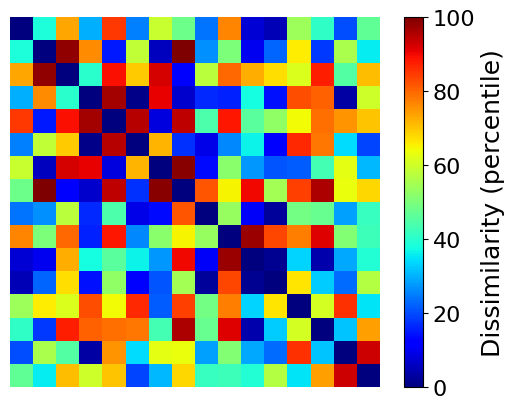

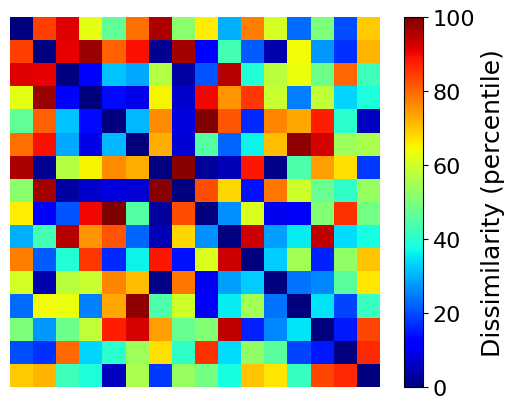

In [45]:
# Plot the RDM of -100ms, 0ms, 50ms, 100ms, 150ms, 200ms
times = [0, 10, ]
for t in times:
    plot_rdm(rdms[1,t], percentile=True)

In [46]:
'''
构造模型矩阵
'''

RDM_model_fuyin = np.zeros([16,16], dtype=np.float32)
# for i in range(20):
#     for j in range(20):
#         if abs(i-j)<=3:
#             RDM_model_fuyin[i,j] = 0
#         else:
#             RDM_model_fuyin[i,j] =
zeroM = np.zeros([4,4], dtype=np.float32)
oneM =  np.ones((4, 4), dtype=np.float32)

a1=np.concatenate((zeroM,oneM,oneM,oneM),axis = 1)
a2=np.concatenate((oneM,zeroM,oneM,oneM),axis = 1)
a3=np.concatenate((oneM,oneM,zeroM,oneM),axis = 1)
a4=np.concatenate((oneM,oneM,oneM,zeroM),axis = 1)

RDM_model_fuyin = np.concatenate((a1,a2,a3,a4),axis=0)


In [47]:
# Calculate the representational similarity between 200ms and all the time points
# （sub,times,2）
corrs1 = rdms_corr(RDM_model_fuyin, rdms)


Computing similarities

Computing finished!



Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
355ms to 375ms


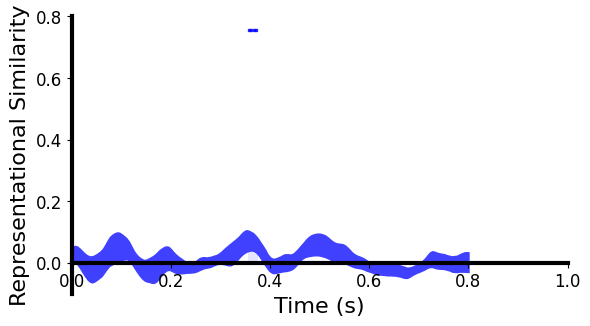

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [48]:
# Plot the corrs1
# corrs1 = np.reshape(corrs1, [1, 191, 2])
# plot_corrs_by_time(corrs1, time_unit=[-0.2, 0.005])
from neurora.rsa_plot import plot_tbytsim_withstats

#配合RDMS的时间窗是 50ms，步长是5ms = 0.005
plot_tbytsim_withstats(corrs1, start_time=-0.15, end_time=0.805, time_interval=0.005, p=0.05,clusterp=0.05,stats_time=[0,0.8],color='b')


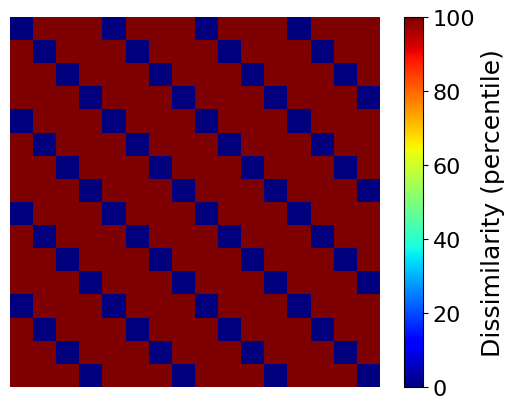


Computing similarities

Computing finished!

Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
605ms to 760ms


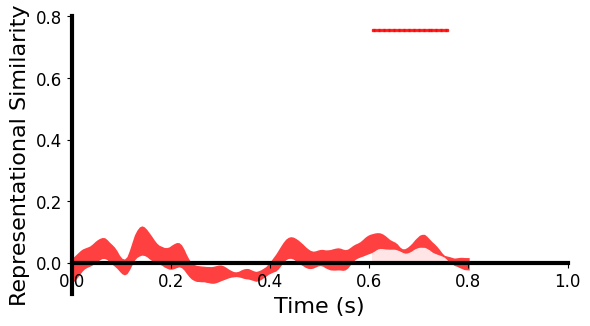

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [49]:

'''
构造模型矩阵
'''

RDM_model_yindiao = np.zeros([16,16], dtype=np.float32)


oneM =  np.ones((4, 4), dtype=np.float32)
for i in range(4):
    oneM[i][i] = 0
zeroM = oneM

a1=np.concatenate((zeroM,oneM,oneM,oneM,),axis = 1)
a2=np.concatenate((oneM,zeroM,oneM,oneM,),axis = 1)
a3=np.concatenate((oneM,oneM,zeroM,oneM,),axis = 1)
a4=np.concatenate((oneM,oneM,oneM,zeroM,),axis = 1)

RDM_model_yindiao = np.concatenate((a1,a2,a3,a4),axis=0)

plot_rdm(RDM_model_yindiao, percentile=True)

# Calculate the representational similarity between 200ms and all the time points
corrs1 = rdms_corr(RDM_model_yindiao, rdms)


from neurora.rsa_plot import plot_tbytsim_withstats

#配合RDMS的时间窗是 50ms，步长是5ms = 0.005
plot_tbytsim_withstats(corrs1, start_time=-0.15, end_time=0.805, time_interval=0.005, p=0.05,clusterp=0.1,stats_time=[0,0.8])

In [ ]:

'''

更精细的构造方法 slope和height

'''

import math
import numpy as np

df = pd.read_excel('E:\实验\阅读困难\数据处理\pre2beishi_RSA_ASSR46\RSA\刺激space\\f0的slope和height.xlsx')

RDM_model_double = np.zeros([20,20], dtype=np.float32)
for i in range(len(df)):

    height1 = df['height'][i]
    slope1 = df['slope'][i]

    for j in range(len(df)):

        height2= df['height'][j]
        slope2 = df['slope'][j]

        '''
        计算公式
        '''
        distance = math.sqrt(math.pow((height2-height1),2)+math.pow((slope2-slope1),2))
        # print(distance)

        '''
        填写到合适的矩阵位置上。
        '''
        RDM_model_double[i][j] = distance

In [14]:
# Calculate the representational similarity between 200ms and all the time points
corrs1 = rdms_corr(RDM_model_double, rdms)


from neurora.rsa_plot import plot_tbytsim_withstats

#配合RDMS的时间窗是 50ms，步长是5ms = 0.005
plot_tbytsim_withstats(corrs1, start_time=-0.15, end_time=0.805, time_interval=0.005, p=0.1,clusterp=0.1,stats_time=[0,0.8])


NameError: name 'RDM_model_double' is not defined

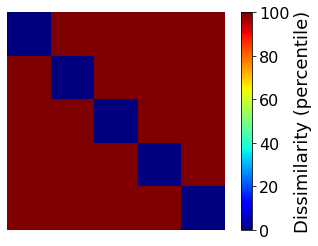

0

In [24]:
plot_rdm(RDM_model_fuyin, percentile=True)

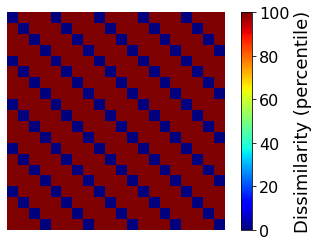

0

In [25]:
plot_rdm(RDM_model_yindiao, percentile=True)